In [1]:
import visa
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import datetime
import os

rm = visa.ResourceManager()

In [23]:
#### Conectar instrumento ####

instruments = (rm.list_resources())
print(instruments)
pico = rm.open_resource(instruments[0])
del pico.timeout


#### Configura instrumento ####

print(pico.query("*IDN?"))
pico.write("CONF:CURR")
pico.query("*OPC?")

('ASRL4::INSTR',)
KEITHLEY INSTRUMENTS INC.,MODEL 6487,1011608,A03   Jun 11 2003 15:25:16/A02  /B/E



'1\n'

In [10]:
### Parametros de entrada ###

voltage = 1
pontos = 20 # determina o scan rate (20 pontos temos scan rate de 110 mV/s)
Sample = 13
Day = 2
Condition = 'hyd'
Direction = 'dielec'
Run = 0
path1 ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\".format(Sample, Day)
nome_arq = path1+"S{}_IV-{}-{}_a{}".format(Sample, Direction, Condition, Run)
date = f"{datetime.datetime.now():%d/%m/%y %H:%M}"
comment = 'IV {} {} {}'.format(Direction, Condition, date)
ciclos = 1
SingleScan = 0
full = 1
pos = 0
neg = 0
voltage_space = np.zeros(voltage*pontos+1)

if full == 1:
    voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
    voltage_space_2 = np.linspace(voltage, 0, pontos + 1, endpoint=True)
    voltage_space_3 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
    voltage_space_4 = np.linspace(-voltage, 0, pontos + 1, endpoint=True)
    voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2[:-1], voltage_space_3[:-1], voltage_space_4), axis=0)

elif pos == 1:
    if SingleScan == 0:
        voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
        voltage_space_2 = np.linspace(voltage, 0, pontos + 1, endpoint=True)
        voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2,), axis=0)
    elif SingleScan == 1:
        voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
        voltage_space = voltage_space_1

elif neg == 1:
    if SingleScan == 0:
        voltage_space_1 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
        voltage_space_2 = np.linspace(-voltage, 0, pontos + 1, endpoint=True)
        voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2,), axis=0)
    elif SingleScan == 1:
        voltage_space_1 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
        voltage_space = voltage_space_1


0.11308116073643198
3.498791534999999e-06


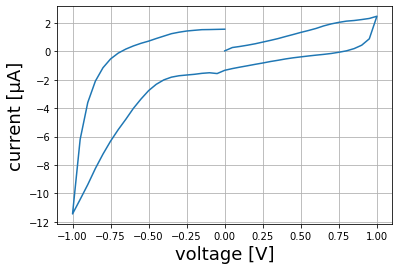

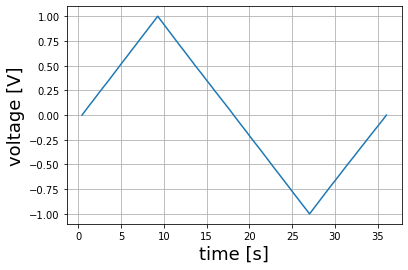

In [11]:
### aquisição de dados ###

tempo  = np.empty(shape=[0])
voltage = np.empty(shape=[0])
current  = np.empty(shape=[0])
t_i = time.time()
pico.write("CURRent:RANGe:UPPer 0.00002")

for j in range(0, ciclos):
    for v in voltage_space:
        pico.write("SOURce:VOLTage:AMPLitude "+str(v))
        pico.query("*OPC?")
        medida = pico.query("READ?")
        pico.query("*OPC?")
        tempo = np.append(tempo, [(time.time() - t_i)], axis=0)
        voltage = np.append(voltage, [v], axis=0)
        current = np.append(current, [float(medida.split(',')[0][:-1])], axis=0)

pico.write("SOURce:VOLTage:AMPLitude 0")
pico.close()

### arquivo ###

#### scan rate ####
y = voltage[:]
x = tempo[:]

dvdt_array = abs(np.diff(y) / np.diff(x)) 

dvdt = np.average(dvdt_array[0:9])

#### capacitance ####

int_ida = np.trapz(current[2*(pontos)+1:(3*(pontos)+2)], voltage[2*(pontos)+1:(3*(pontos)+2)])
int_volta = np.trapz(current[3*(pontos)+1:(4*(pontos)+2)], voltage[3*(pontos)+1:(4*(pontos)+2)])
int_total = int_ida - int_volta

#### data ####

arq = open(nome_arq, 'w')
arq.write(str(comment)+ '\t' + 'scan rate =' + str(dvdt) +'\t V/s\t' + 'capacitance =' + str(int_total) +'F' + '\n')
arq.write('time (s)\tvoltage (V)\tcurrent (A)\n' )
for i in range(len(tempo)):
    arq.write(str(tempo[i]) + '\t')
    arq.write(str(voltage[i]) + '\t')
    arq.write(str(current[i]) + '\n')
arq.close()

### gráfico ###

print (dvdt)
print (int_total)

plt.plot(voltage,current*(1E6))
plt.grid(True)
plt.xlabel('voltage [V]', fontsize=18)
plt.ylabel('current [\u03bcA]', fontsize=18)

plt.show()

plt.plot(tempo,voltage)
plt.grid(True)
plt.ylabel('voltage [V]', fontsize=18)
plt.xlabel('time [s]', fontsize=18)

plt.show()

Text(0, 0.5, 'current [μA]')

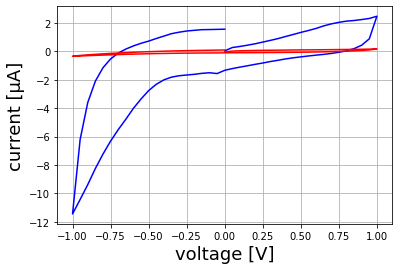

In [12]:
fig=plt.figure()
#plt.title('Au electrode')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
#plt.yscale('log')
#plt.yscale('log')
path ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE13\\DAY1\\"
path2 ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE13\\DAY2\\"
graph2 = np.genfromtxt(path+"S13_IV-dielec-AP_a0", skip_header=2)
graph1 = np.genfromtxt(path2+"S13_IV-dielec-hyd_a0", skip_header=2)
#graph = np.genfromtxt(path1+"S12_IV-semic-hyd_a2", skip_header=2)
plt.plot(graph1[:,1], (graph1[:,2])*(1E6), color='blue')
plt.plot(graph2[:,1], (graph2[:,2])*(1E6), color='red')
#plt.plot(graph[:,1], (graph[:,2])*(1E6))
plt.grid(True)
plt.xlabel('voltage [V]', fontsize=18)
plt.ylabel('current [\u03bcA]', fontsize=18)

In [24]:
### Parametros de entrada ###

#scan_rates = [440, 2200] # scan rates (110,90,75,50,40,30,20,10,5,1) mV/s
scan_rates = [73]
#scan_rates = [20, 24, 28, 44, 55, 73, 110, 220, 440, 2200]
Sample = 13
Day = 2
Condition = 'hyd'

for index in range(len(scan_rates)):

    voltage = 1
    pontos = scan_rates[index] # determina o scan rate (20 pontos temos scan rate de 110 mV/s)
    path1 ="D:\\DriveUnicamp\\UNICAMP\\Doutorado\\BEPE\\Resultados\\LBL_IDEAu_SH\\New_PEDOT\\SAMPLE{}\\DAY{}\\RAW\\".format(Sample,Day)
    date = f"{datetime.datetime.now():%d/%m/%y %H:%M}"
    comment = 'IV dielec 3 pos cycles {} {}'.format(Condition, date)
    ciclos = 3
    SingleScan = 0
    full = 0
    pos = 1
    neg = 0
    voltage_space = np.zeros(voltage*pontos+1)

    if full == 1:
        voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
        voltage_space_2 = np.linspace(voltage, 0, pontos + 1, endpoint=True)
        voltage_space_3 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
        voltage_space_4 = np.linspace(-voltage, 0, pontos + 1, endpoint=True)
        voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2[:-1], voltage_space_3[:-1], voltage_space_4), axis=0)
        volt_ampl = 2*voltage
        
    elif pos == 1:
        if SingleScan == 0:
            voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
            voltage_space_2 = np.linspace(voltage, 0, pontos + 1, endpoint=True)
            voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2,), axis=0)
            volt_ampl = voltage
        elif SingleScan == 1:
            voltage_space_1 = np.linspace(0, voltage, pontos + 1, endpoint=True)
            voltage_space = voltage_space_1
            volt_ampl = voltage

    elif neg == 1:
        if SingleScan == 0:
            voltage_space_1 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
            voltage_space_2 = np.linspace(-voltage, 0, pontos + 1, endpoint=True)
            voltage_space = np.concatenate((voltage_space_1[:-1], voltage_space_2,), axis=0)
            volt_ampl = voltage
        elif SingleScan == 1:
            voltage_space_1 = np.linspace(0, -voltage, pontos + 1, endpoint=True)
            voltage_space = voltage_space_1
            volt_ampl = voltage         

### aquisição de dados ###

    tempo  = np.empty(shape=[0])
    voltage = np.empty(shape=[0])
    current  = np.empty(shape=[0])
    t_i = time.time()
    pico.write("CURRent:RANGe:UPPer 0.00002")

    for j in range(0, ciclos):
        for v in voltage_space:
            pico.write("SOURce:VOLTage:AMPLitude "+str(v))
            pico.query("*OPC?")
            medida = pico.query("READ?")
            pico.query("*OPC?")
            tempo = np.append(tempo, [(time.time() - t_i)], axis=0)
            voltage = np.append(voltage, [v], axis=0)
            current = np.append(current, [float(medida.split(',')[0][:-1])], axis=0)
        nome_arq = path1+"S{}_IV-dielec-{}_a".format(Sample, Condition)+str(index+5)+"_scan"+str(j+1)
        arq = open(nome_arq, 'w')
        arq.write('time (s)\tvoltage (V)\tcurrent (A)\n' )
        for i in range(len(tempo)):
            arq.write(str(tempo[i]) + '\t')
            arq.write(str(voltage[i]) + '\t')
            arq.write(str(current[i]) + '\n')
        arq.close()
        #plt.plot(voltage,current*(1E6))
        #plt.grid(True)
        #plt.xlabel('voltage [V]', fontsize=18)
        #plt.ylabel('current [\u03bcA]', fontsize=18)
        #plt.show()
        voltage = []
        current = []
        tempo = []
            

    pico.write("SOURce:VOLTage:AMPLitude 0")
    time.sleep(30)

pico.close()

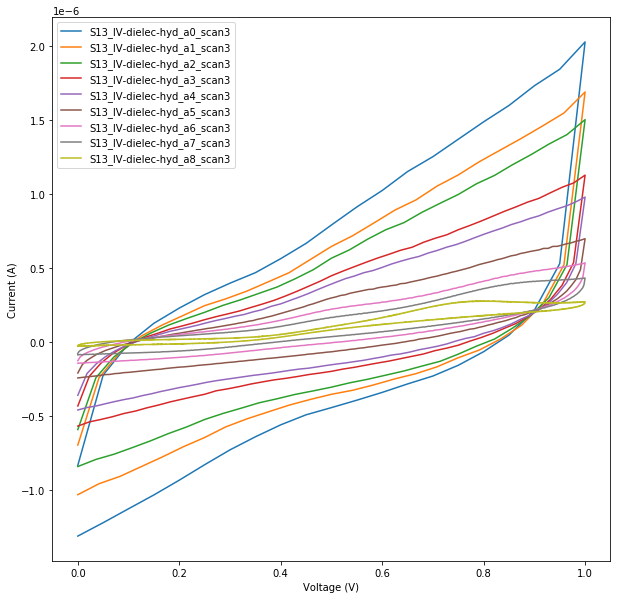

In [22]:
arq = [x for x in os.listdir(path1) if x.endswith("scan3")]
arq

plt.figure(figsize=(10,10))
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
#plt.subplot(121)
#plt.title('PEI external')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
#plt.yscale('log')

for x in range(len(arq)):
    leg = str(arq[x])
    file0= np.genfromtxt(path1+arq[x],skip_header=1)
    plt.plot(file0[:,1], (file0[:,2]),label=leg)
    plt.legend()
#len(file0)